# Case Analysis including actions

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

## Creating Training Data

We will run one round of the demonstration that trains on data that ends at a date earlier than the last date we have on our dataset. This way we can compare how well our model predicts to the real value in our data. The last date in this `states_combined_data.csv` contains up to `5/29/20`. 

In [1]:
# Load Built-in Modules
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle

# Ignore Python package warnings (not verbose)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# paths
DIRECTORY_PATH = os.path.dirname(os.getcwd())
os.chdir(DIRECTORY_PATH)

DATA_PATH   = os.path.join(os.getcwd(), "data", "input")
RESULT_PATH = os.path.join(os.path.dirname(os.getcwd()), "results")
MODEL_PATH  = os.path.join(os.getcwd(), "models")

In [3]:
# experiment name
EXPERIMENT_FOLDER = "01 - Cross-validation by state"  # not used for now
try: 
    assert os.path.exists(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))
except AssertionError:
    os.mkdir(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))

In [4]:
# Load MDP packages
import codes.mdp_model as mdp
from codes.mdp_testing import mape, plot_pred, plot_pred_action, plot_pred_fact
from codes.mdp_states_functions import createSamples
# from codes.utils import run_script # for multiprocessing

In [6]:
MODEL_PATH

'C:\\Users\\david\\Desktop\\MIT\\Courses\\Research internship\\covid19_team2\\models'

In [5]:
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.head()

Unnamed: 0    state        date  cases  deaths  population  emergdec  \
0           0  Alabama  2020-01-22      0       0   4903185.0         0   
1           1  Alabama  2020-01-23      0       0   4903185.0         0   
2           2  Alabama  2020-01-24      0       0   4903185.0         0   
3           3  Alabama  2020-01-25      0       0   4903185.0         0   
4           4  Alabama  2020-01-26      0       0   4903185.0         0   

   schoolclose  barrestrict  gathrestrict25  ...  workplaces  residential  \
0            0            0               0  ...         NaN          NaN   
1            0            0               0  ...         NaN          NaN   
2            0            0               0  ...         NaN          NaN   
3            0            0               0  ...         NaN          NaN   
4            0            0               0  ...         NaN          NaN   

   recovered  active  incident_rate  people_tested  people_hospitalized  \
0        NaN     NaN            NaN            NaN                  NaN   
1        NaN     NaN            NaN            NaN                  NaN   
2        NaN     NaN            NaN            NaN                  NaN   
3        NaN     NaN            NaN            NaN                  NaN   
4        NaN     NaN            NaN            NaN                  NaN   

   mortality_rate  testing_rate  hospitalization_rate  
0             NaN           NaN                   NaN  
1             NaN           NaN                   NaN  
2             NaN           NaN                   NaN  
3             NaN           NaN                   NaN  
4             NaN           NaN                   NaN  

[5 rows x 44 columns]

We can specify a value `n_days` to create a training dataset that ends `n_days` before this last date. We will also need to give the name of the date column from our `df`. 

## Import fitted model

Now that we understand how the samples are actually created, we can fit the samples to the model! Here, there are a few additional parameters that need to be set: 

`h` is the time horizon (in number of datapoints) that we take when calculating error. Essentially, we will be calculating the error of the most recent `h` points from the end. The goal of the algorithm is to minimize `testing_error`, so `testing_error` for a sequence of `h=1` points will be much smaller than for `h=5` points. If we are doing a 2 week prediction (`n_days = 14`), `h=5` while `d_avg=3` means that 5 datapoints correspond to a 15 day timespan, which means the algorithm will be minimizing error for around a 2 week period before the last date in the training data. If we take `h=-1`, the algorithm will try to minimize error over all the datapoints available in the training data.

`n_iter` is the maximum number of clusters we want the algorithm to stop at while training. Initial clustering is done using `clustering='Agglomerative'`, with a `distance_threshold = 0.1`, based on `RISK`. The algorithm will then split the cluster that contains the most contradictions (two points in the cluster taking the same action but ending up in different clusters), so one cluster becomes two. For points in the same cluster that don't take the action causing the contradiction, the group they enter is decided by `classification = 'DecisionTreeClassifier'`, which learns which group they are closer to based on their features. Splitting will stop when `n_iter` number of total clusters is reached.

`th` is the splitting threshold, which basically allows the split to happen if the number of points in contradiction within a cluster is greater than this `th` value. 

`model.fit` will also automatically run cross validation by splitting the dataset randomly into `cv=5` combinations of testing & training, where each `ID` (state) will be in the testing set exactly once. After cross validation, it will find the number of clusters that gives the smallest `testing_error`, and split the entire dataset once more to this exact number of clusters. Now let's run it!

In [7]:
# # Setting parameters
n_days = 15
date_col = 'date'
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
days_avg = 3

# model names deaths with actions
model_name = "mdp_timecv150_DT_h8_10pct_cases_wo_act.pickle"

In [8]:
with open(os.path.join(MODEL_PATH, model_name), 'rb') as filehandler:
    m = pickle.load(filehandler)

In [9]:
m

MDPModel(target=cases, horizon=8, days_avg=3,distance_threshold=10pct, n_iter=150, classification_algorithm=DecisionTreeClassifier, features_list=['mobility_score_trend', 'cases_pct3', 'cases_pct5'],action_thresh=([-250, 200], 1))

## Analysis of the MDP

In [10]:
m.df_trained

ID       TIME  mobility_score_trend  cases_pct3  \
state                                                                   
Alabama                0 2020-05-22           2384.469388    0.104557   
Alaska                 1 2020-05-22           1296.551020    0.007500   
Arizona                2 2020-05-20           1904.040816    0.073683   
Arkansas               3 2020-05-22           1866.780612    0.139955   
California             4 2020-05-20           1524.295918    0.077017   
Colorado               5 2020-05-22           1570.984694    0.044702   
Connecticut            6 2020-05-21           1400.645408    0.030068   
Delaware               7 2020-05-20           1708.183673    0.065079   
District of Columbia   8 2020-05-21           1062.224490    0.066498   
Florida                9 2020-05-20           1921.122449    0.047597   
Georgia               10 2020-05-21           2330.502551    0.064889   
Hawaii                11 2020-05-20           1450.234694    0.005728   
Idaho                 12 2020-05-22           1644.183673    0.057026   
Illinois              13 2020-05-22           1304.020408    0.075630   
Indiana               14 2020-05-20           1684.316327    0.057571   
Iowa                  15 2020-05-22           1186.454082    0.078190   
Kansas                16 2020-05-20           1442.000000    0.058334   
Kentucky              17 2020-05-21           1631.224490    0.044239   
Louisiana             18 2020-05-21           1896.275510    0.052786   
Maine                 19 2020-05-22           1588.959184    0.118897   
Maryland              20 2020-05-21           1578.188776    0.082031   
Massachusetts         21 2020-05-20           1302.010204    0.034318   
Michigan              22 2020-05-20           1625.265306    0.032362   
Minnesota             23 2020-05-22           1364.030612    0.116037   
Mississippi           24 2020-05-20           2249.204082    0.069066   
Missouri              25 2020-05-21           1816.849490    0.039323   
Montana               26 2020-05-20           1177.234694    0.019167   
Nebraska              27 2020-05-22           1273.443878    0.074443   
Nevada                28 2020-05-22           1664.061224    0.060457   
New Hampshire         29 2020-05-22           1594.413265    0.078742   
New Jersey            30 2020-05-21           1130.030612    0.022075   
New Mexico            31 2020-05-20           1501.132653    0.065145   
New York              32 2020-05-22            957.862245    0.015046   
North Carolina        33 2020-05-21           2033.316327    0.108586   
North Dakota          34 2020-05-20           1262.683673    0.139647   
Ohio                  35 2020-05-21           1641.943878    0.061912   
Oklahoma              36 2020-05-20           2041.285714    0.053212   
Oregon                37 2020-05-22           1377.709184    0.037037   
Pennsylvania          38 2020-05-22           1390.270408    0.043084   
Rhode Island          39 2020-05-22           1375.443878    0.060613   
South Carolina        40 2020-05-22           2254.515306    0.064267   
South Dakota          41 2020-05-20           1165.285714    0.050415   
Tennessee             42 2020-05-20           2273.000000    0.055580   
Texas                 43 2020-05-22           1862.153061    0.059088   
Utah                  44 2020-05-20           1751.806122    0.067755   
Vermont               45 2020-05-21           1263.045918    0.009556   
Virginia              46 2020-05-21           1687.293367    0.091752   
Washington            47 2020-05-21           1596.647959    0.025662   
West Virginia         48 2020-05-22           1677.122449    0.135153   
Wisconsin             49 2020-05-20           1572.755102    0.093686   
Wyoming               50 2020-05-21           1091.645408    0.040243   

                      cases_pct5  mobility_score_trend-1  \
state                                                      
Alabama                 0.161329

In [11]:
m.features_list

['mobility_score_trend', 'cases_pct3', 'cases_pct5']

In [12]:
m.clustering_distance_threshold

0.1

We have our model ready for interpretation! Let's first look at some attributes that were stored in the model after training. First, we can see how many clusters it actually ended up with at the final optimal split, as well as the training error of the lowest point of CV: 

In [13]:
print(m.optimal_cluster_size)
print(m.CV_error)
m.verbose=False

48
0.11268562976646061


Now, we can run `model.predict_region_ndays`, which takes a state name and a time horizon `n_days`, and returns the predicted number of cases after `n_days` from the most recent datapoint. (For later comparison purposes, since we created the training data using `n_days = 15`, we should pick an `n_days` that is less than that to compare with the real value.)

In [14]:
m.predict_region_ndays('New York', 15)

382139.65599916806

`model.predict_all` does the same thing, but for all the states for a given `n_days`. It returns a dataframe instead of just a number.

In [15]:
m.predict_allregions_ndays(15)

TIME   cases
state                                  
Alabama              2020-06-06   16820
Alaska               2020-06-06     429
Arizona              2020-06-04   19081
Arkansas             2020-06-06    7351
California           2020-06-04  109919
Colorado             2020-06-06   28454
Connecticut          2020-06-05   42064
Delaware             2020-06-04   10443
District of Columbia 2020-06-05    9647
Florida              2020-06-04   58796
Georgia              2020-06-05   50538
Hawaii               2020-06-04     687
Idaho                2020-06-06    3143
Illinois             2020-06-06  129745
Indiana              2020-06-04   36757
Iowa                 2020-06-06   20292
Kansas               2020-06-04   10680
Kentucky             2020-06-05   10123
Louisiana            2020-06-05   44479
Maine                2020-06-06    2430
Maryland             2020-06-05   54873
Massachusetts        2020-06-04  109011
Michigan             2020-06-04   64787
Minnesota            2020-06-06   23713
Mississippi          2020-06-04   15311
Missouri             2020-06-05   14250
Montana              2020-06-04     510
Nebraska             2020-06-06   14128
Nevada               2020-06-06    9116
New Hampshire        2020-06-06    4862
New Jersey           2020-06-05  162267
New Mexico           2020-06-04    8074
New York             2020-06-06  382139
North Carolina       2020-06-05   27916
North Dakota         2020-06-04    3160
Ohio                 2020-06-05   37505
Oklahoma             2020-06-04    6997
Oregon               2020-06-06    4122
Pennsylvania         2020-06-06   85060
Rhode Island         2020-06-06   16641
South Carolina       2020-06-06   11676
South Dakota         2020-06-04    5213
Tennessee            2020-06-04   23283
Texas                2020-06-06   64862
Utah                 2020-06-04    9832
Vermont              2020-06-05    1014
Virginia             2020-06-05   43101
Washington           2020-06-05   20476
West Virginia        2020-06-06    2233
Wisconsin            2020-06-04   18205
Wyoming              2020-06-05     971

We can run the following code to visualize the comparative errors between predicted and actual errors in a dataframe.

In [16]:
# Import full dataset and convert time col to time object
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

df_pred = pd.concat([m.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
df_pred.set_index(m.region_colname, inplace=True)
error = mape(df_pred, df_true, m.target_colname).reset_index()
error_state = error.drop("TIME", axis=1).groupby(m.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

rel_error
state                          
New York               0.004303
New Jersey             0.005244
Illinois               0.005316
Florida                0.005514
Ohio                   0.006300
South Dakota           0.007350
Colorado               0.007898
Georgia                0.008246
Vermont                0.008941
Wyoming                0.012155
New Mexico             0.013785
Missouri               0.016760
New Hampshire          0.016911
Indiana                0.017073
Oklahoma               0.017652
Maryland               0.018271
Maine                  0.018336
Montana                0.019139
Nevada                 0.019842
Connecticut            0.022033
Tennessee              0.022223
Massachusetts          0.022665
Idaho                  0.022869
Kentucky               0.024397
Hawaii                 0.027309
District of Columbia   0.028290
Iowa                   0.028366
Pennsylvania           0.030490
Rhode Island           0.030574
Utah                   0.031472
Kansas                 0.033465
Michigan               0.033816
Mississippi            0.034658
Louisiana              0.036538
West Virginia          0.036540
Wisconsin              0.037690
Delaware               0.039795
California             0.041795
Oregon                 0.043170
Arizona                0.050772
Washington             0.052409
North Carolina         0.053541
Texas                  0.054198
Nebraska               0.057412
Arkansas               0.057849
Virginia               0.062061
South Carolina         0.063429
Alaska                 0.066673
Minnesota              0.086933
Alabama                0.098953
North Dakota           0.122500

In [17]:
# computing the out of sample error
error_state.describe()

rel_error
count  51.000000
mean    0.033018
std     0.024803
min     0.004303
25%     0.016992
50%     0.028290
75%     0.042483
max     0.122500

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B07E132688>]],
      dtype=object)

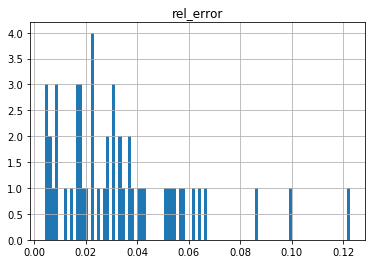

In [18]:
error_state.hist(bins=100)

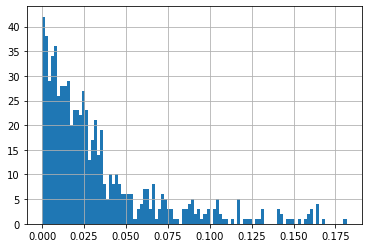

In [19]:
error["rel_error"].hist(bins=100)

Now, the great thing is that literally ALL OF THE ABOVE has been pacakged into a nice function for you, which returns both the trained model and this error dataframe! Simply run the `model_testing` function from the `mdp_model.py` file, and you will get these results!

## Visualization Tools

`plot_pred` allows us to visualize the predicted path of the model compared to the real evolution of the target value.

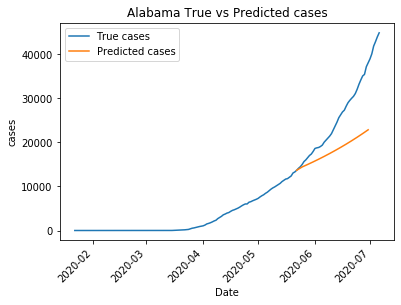

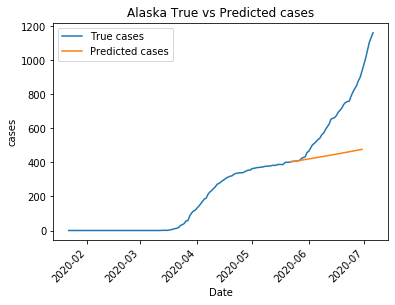

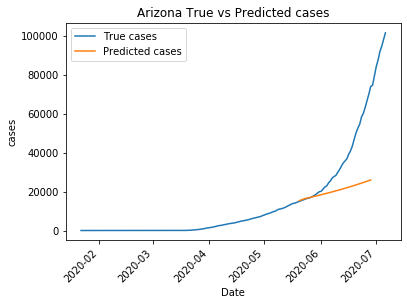

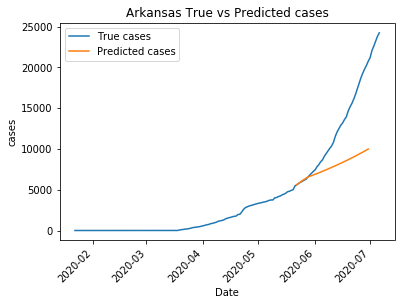

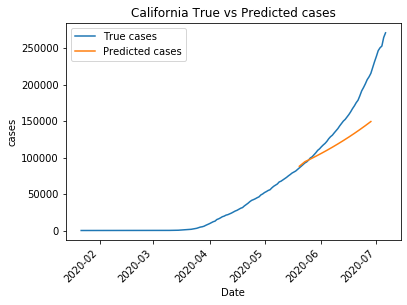

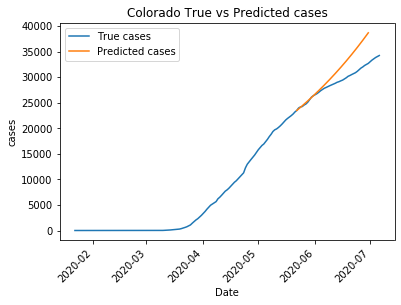

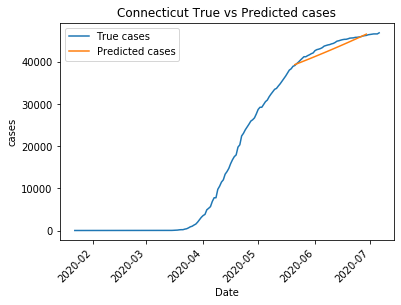

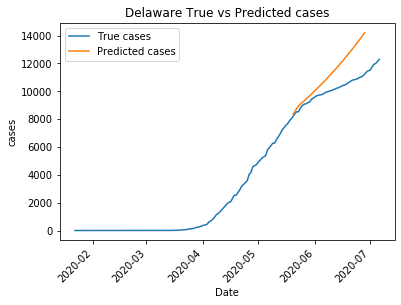

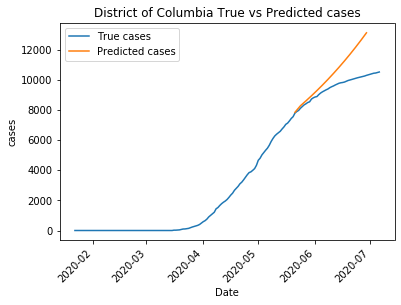

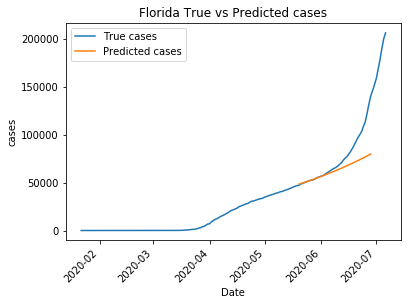

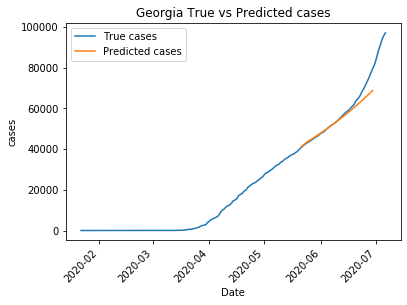

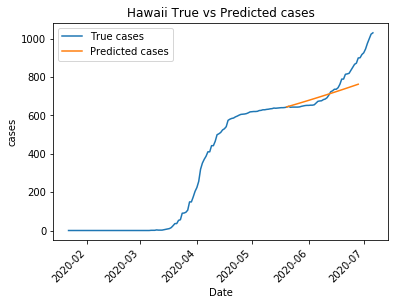

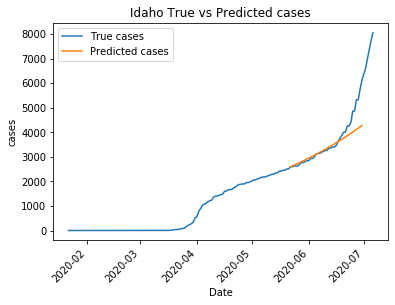

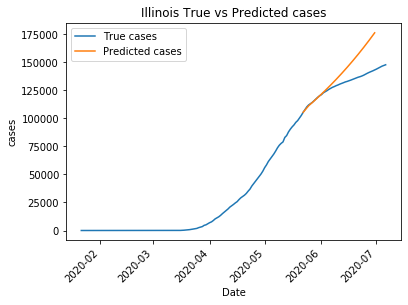

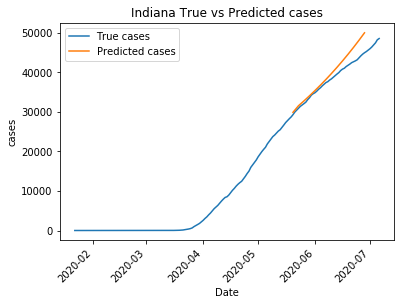

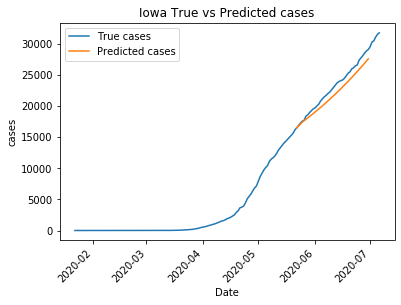

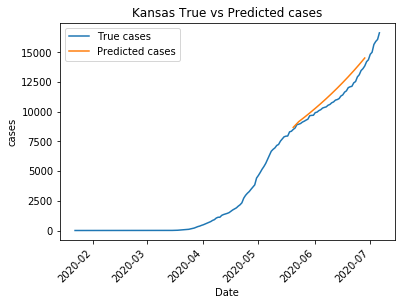

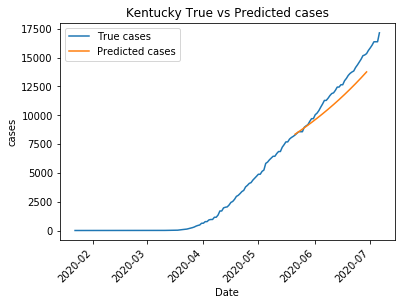

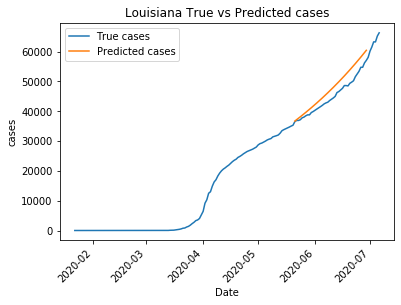

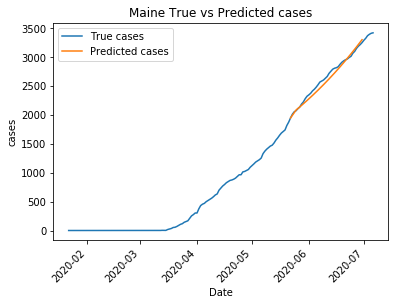

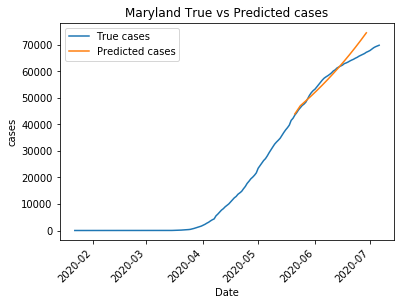

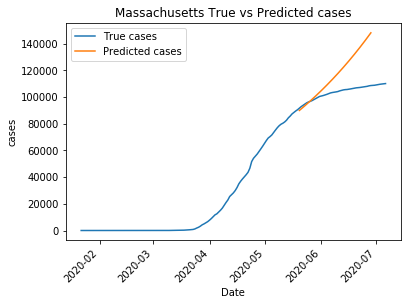

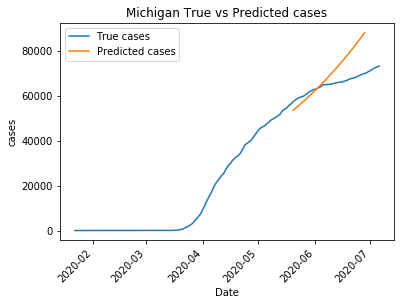

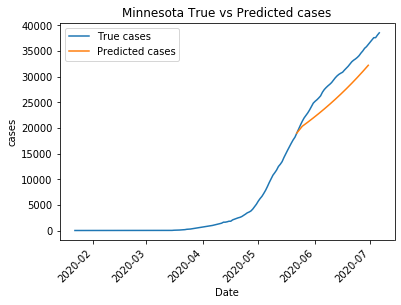

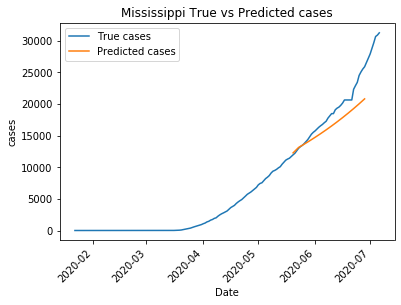

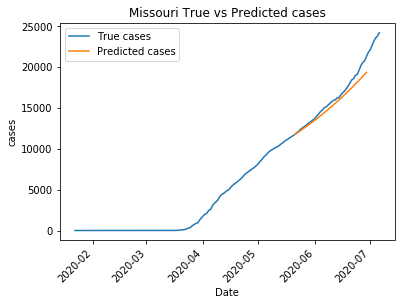

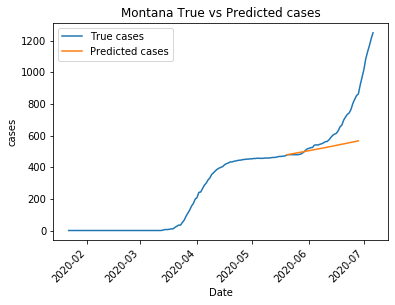

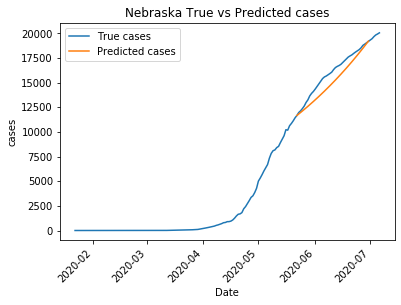

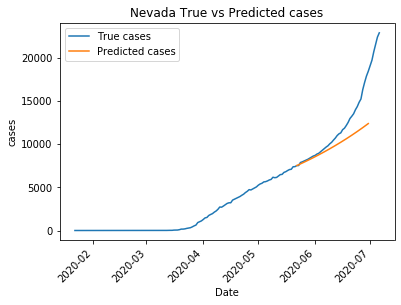

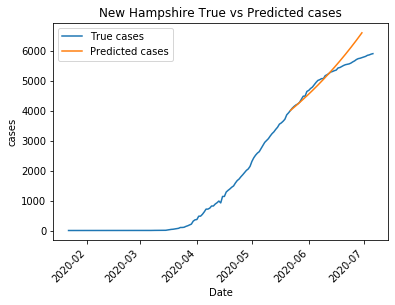

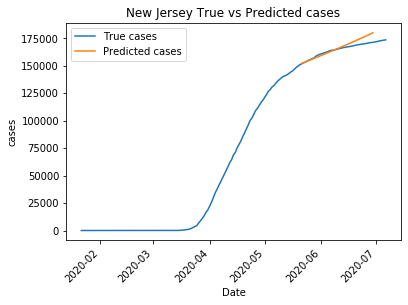

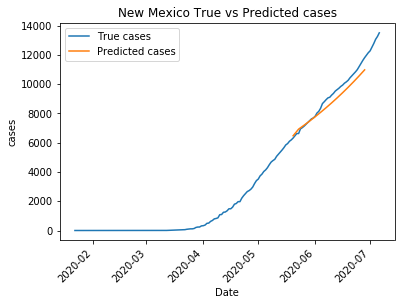

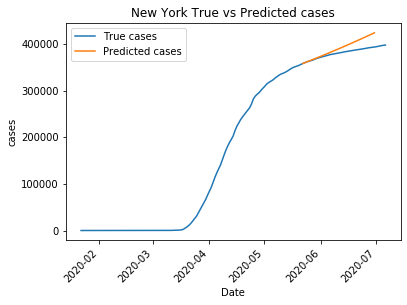

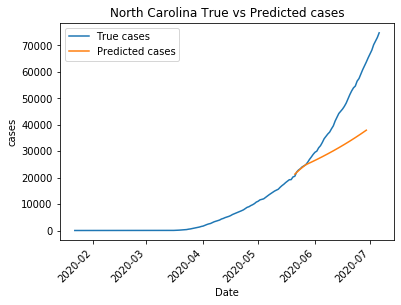

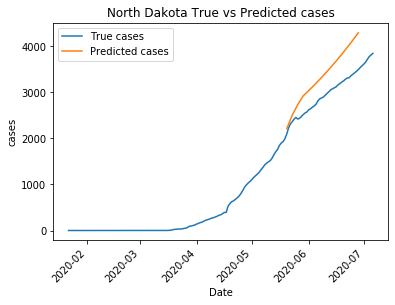

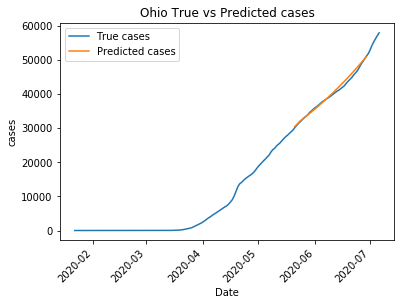

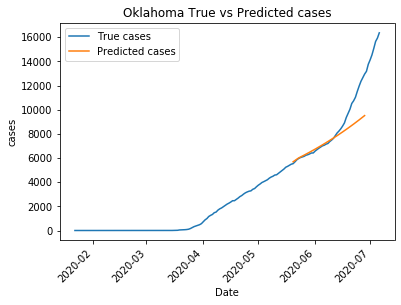

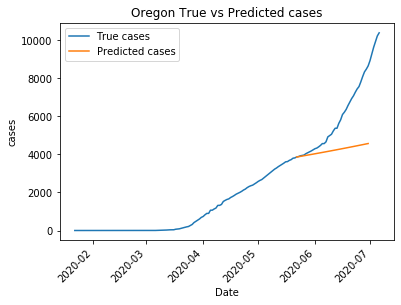

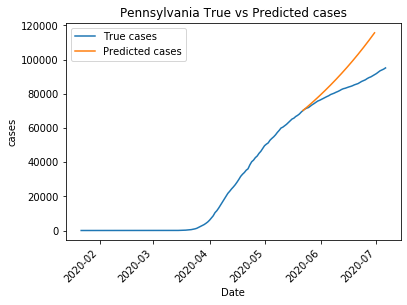

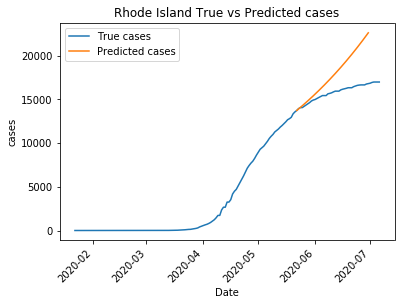

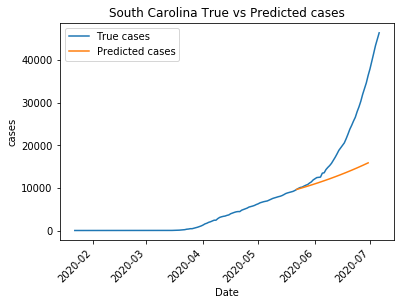

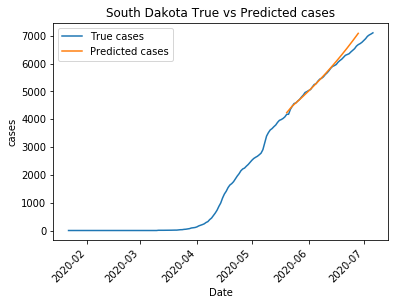

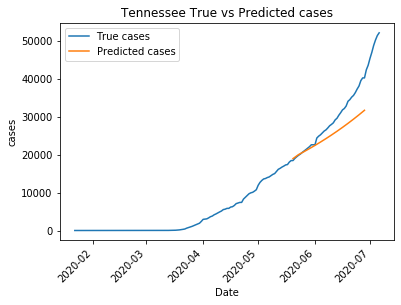

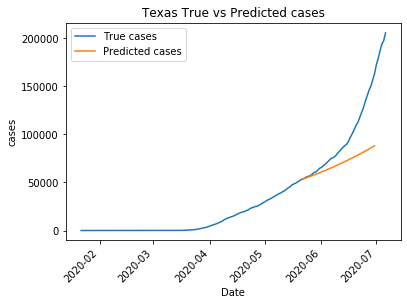

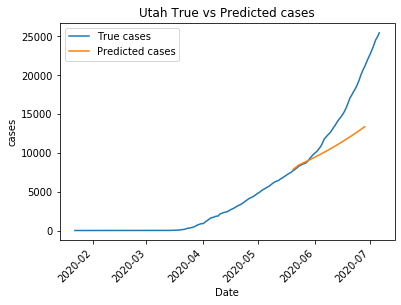

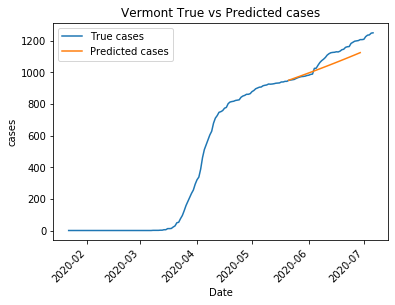

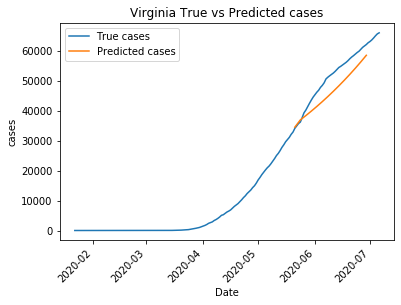

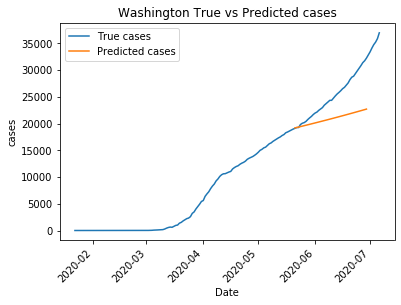

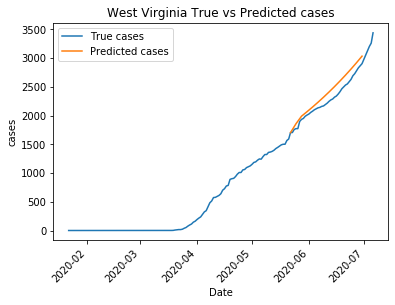

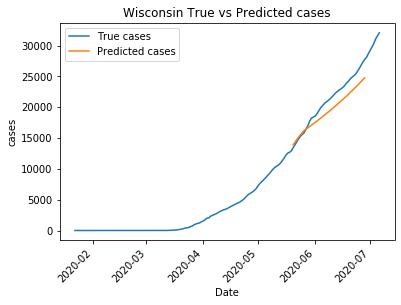

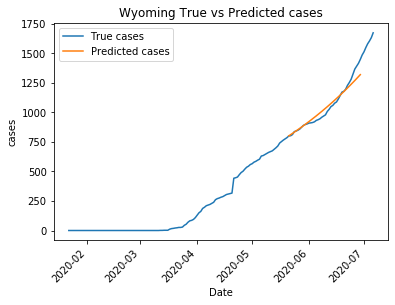

In [20]:
for region in m.df_trained.index:
    plot_pred(m, region, df, 40, from_first=False)

## $\textbf{Grid Search Analysis}$

no model trained currently

In [38]:
# with open(os.path.join(MODEL_PATH, "mdp_gs_act2.pickle"), 'rb') as filehandler:
# # with open(os.path.join(MODEL_PATH, "mdp_gs_w_act.pickle"), 'rb') as filehandler:
#     mgs = pickle.load(filehandler)

In [39]:
# mgs.testing_error

In [40]:
# mgs.best_estimator_

In [41]:
# import operator
# key_opt = min(mgs.testing_error.items(), key=operator.itemgetter(1))[0]
# m_opt = mgs.all_estimators_dict[key_opt]
# m_opt

In [42]:
# m_opt.optimal_cluster_size

In [43]:
# # Import full dataset and convert time col to time object
# file = '07_08_2020_states_combined.csv'
# df = pd.read_csv(os.path.join(DATA_PATH, file))
# df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

# df_pred = pd.concat([m_opt.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
# df_true = df_pred.set_index([m_opt.region_colname, "TIME"]).join(df.rename(columns={m_opt.date_colname: "TIME"}).set_index([m_opt.region_colname, "TIME"])[m_opt.target_colname], lsuffix="_", rsuffix="").loc[:, [m_opt.target_colname]].reset_index().set_index(m_opt.region_colname)
# df_pred.set_index(m_opt.region_colname, inplace=True)
# error = mape(df_pred, df_true, m_opt.target_colname).reset_index()
# error_state = error.drop("TIME", axis=1).groupby(m_opt.region_colname)["rel_error"].mean().to_frame()
# error_state.sort_values("rel_error")

In [44]:
# # computing the out of sample error
# error_state.describe()

In [45]:
# error["rel_error"].hist(bins=100)

## $\textbf{Changing in policy analysis}$

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


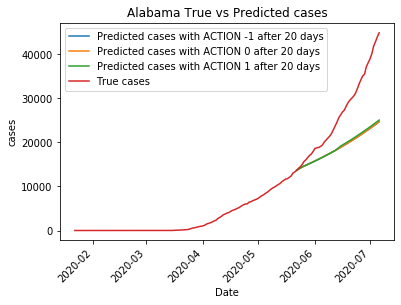

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


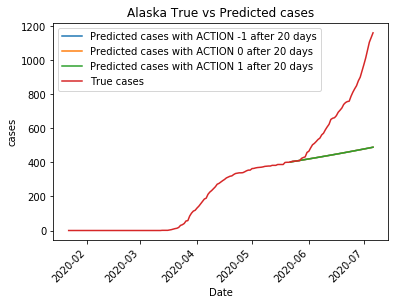

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


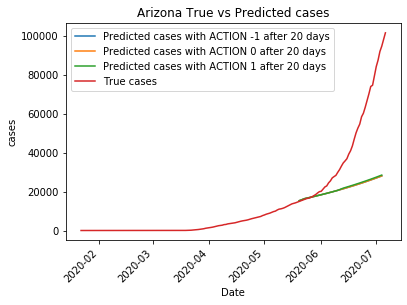

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


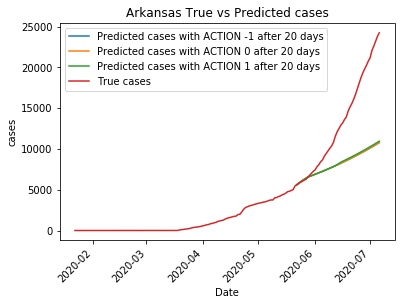

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


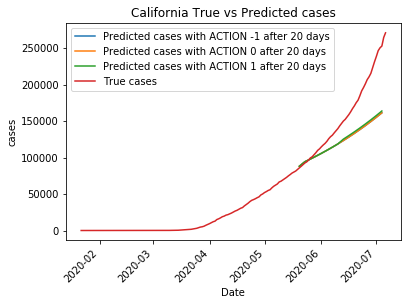

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


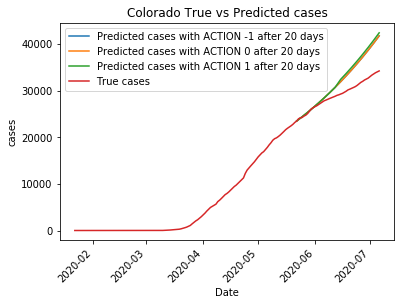

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


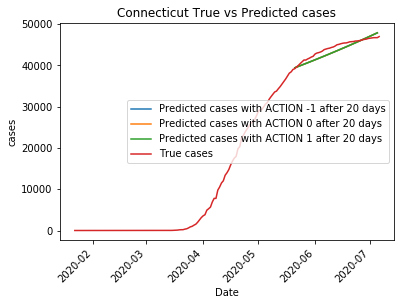

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


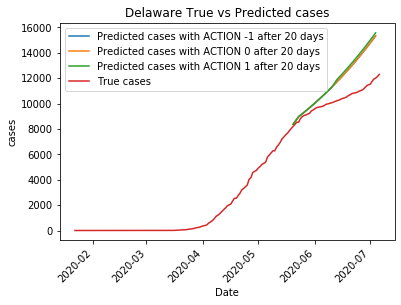

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


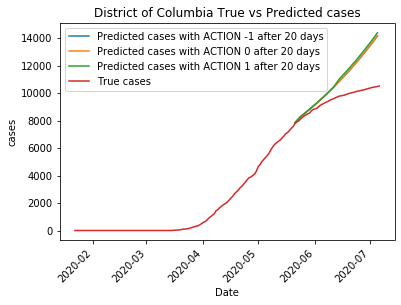

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


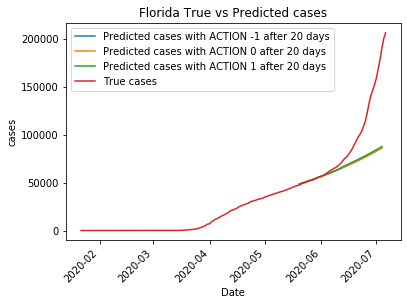

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


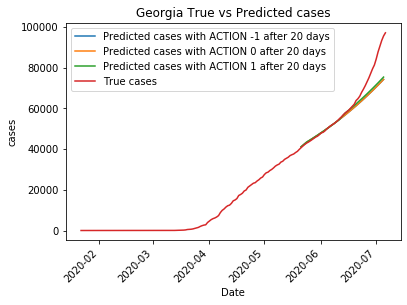

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


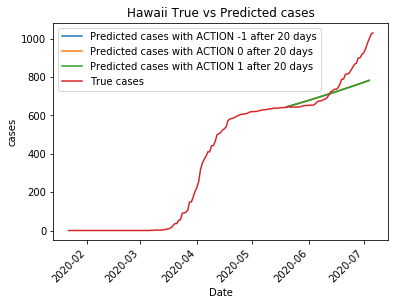

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


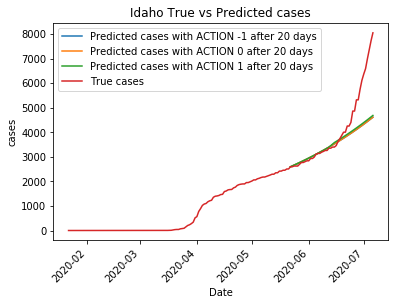

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


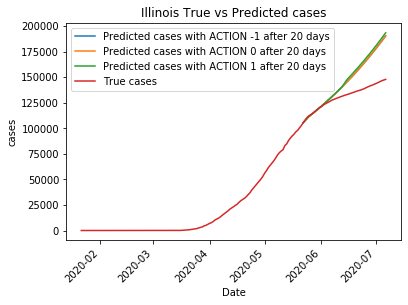

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


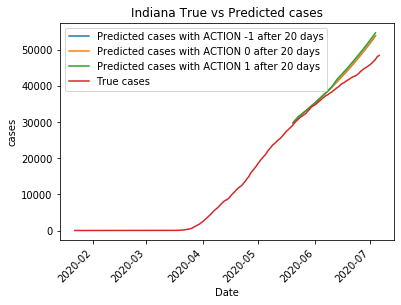

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


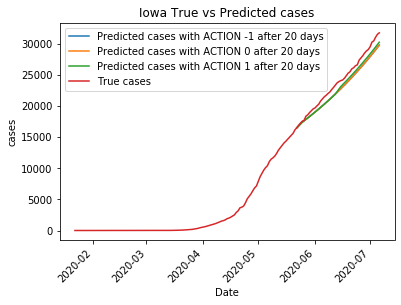

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


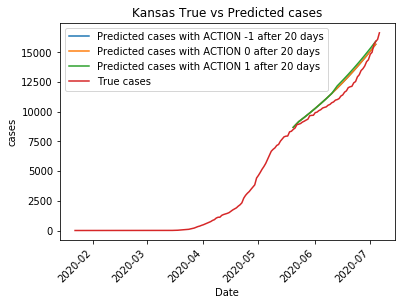

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


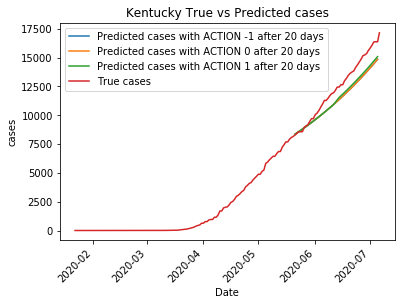

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


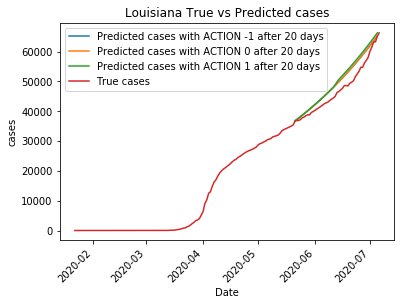

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


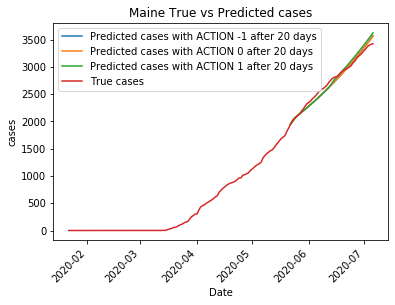

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


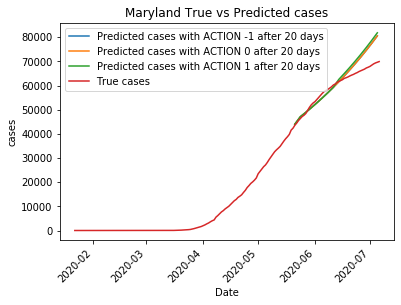

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


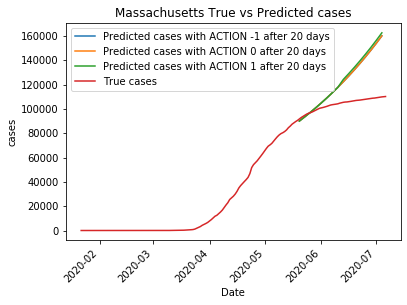

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


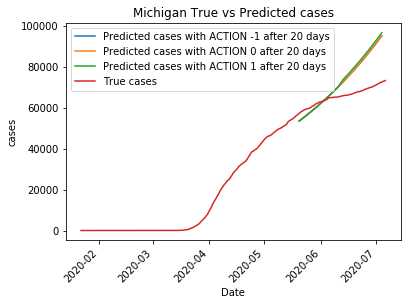

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


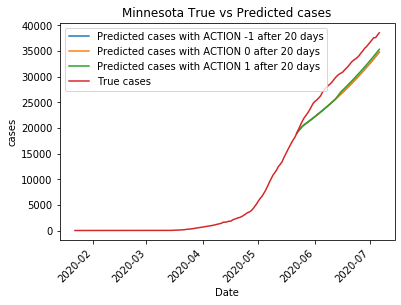

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


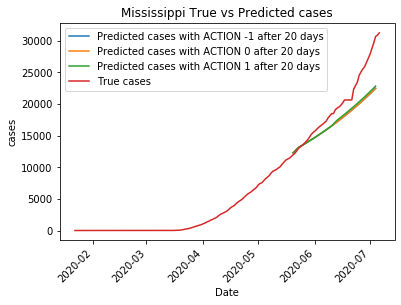

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


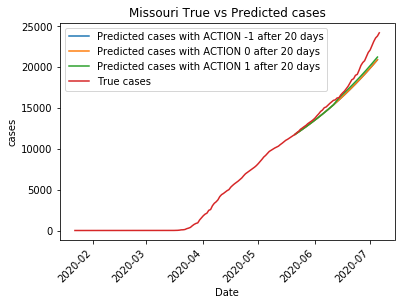

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


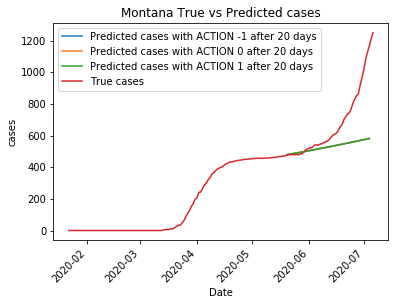

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


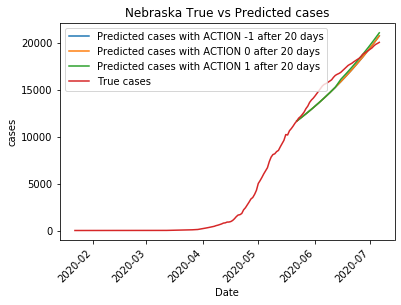

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


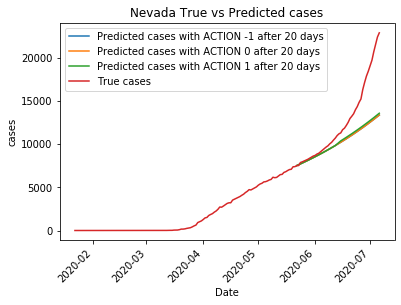

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


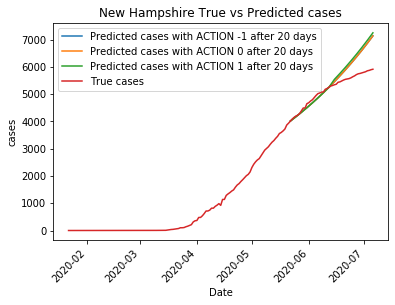

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


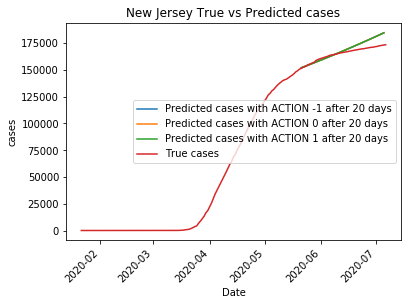

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


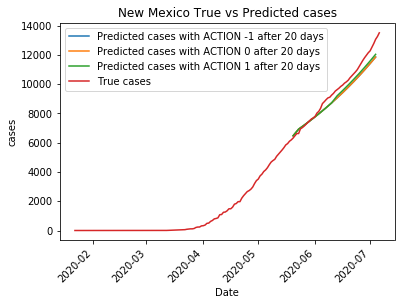

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


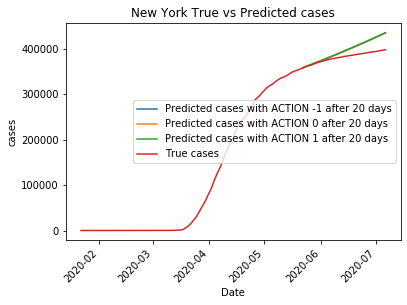

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


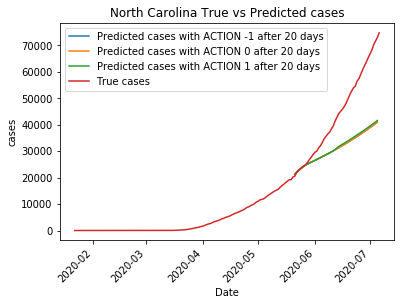

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


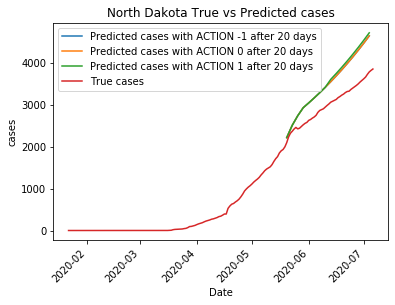

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


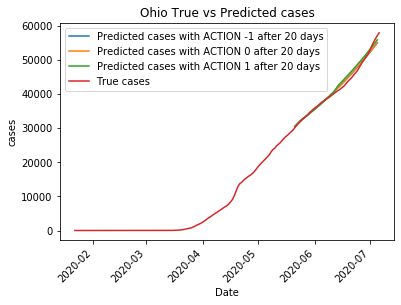

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


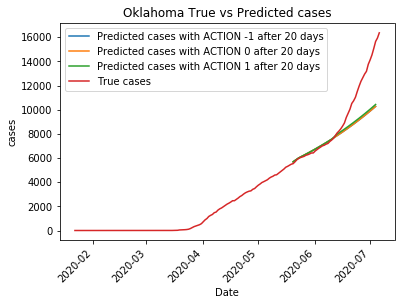

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


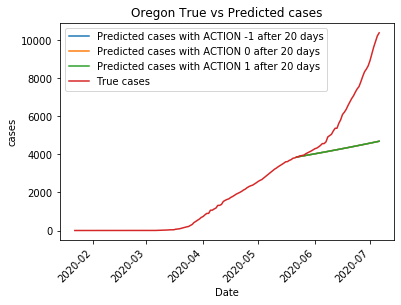

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


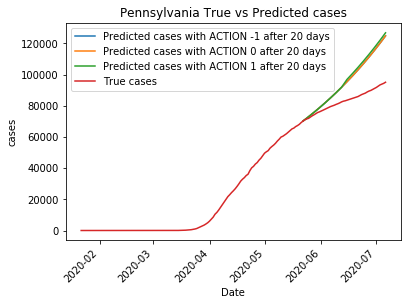

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


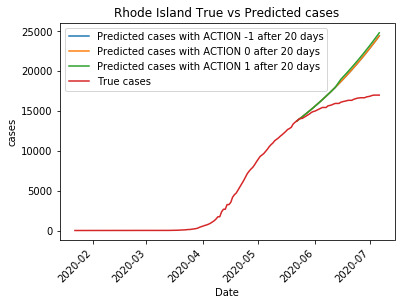

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


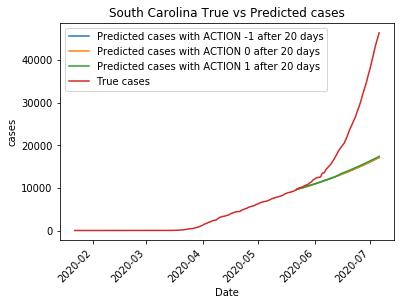

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


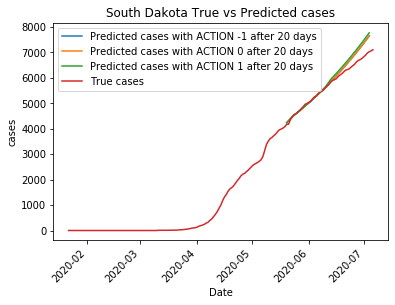

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


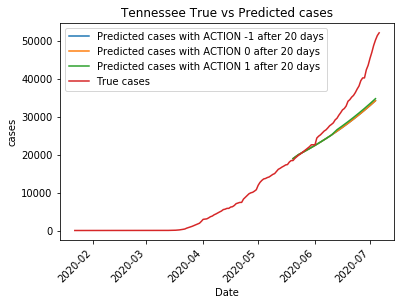

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


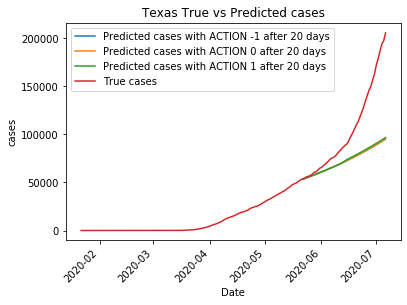

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


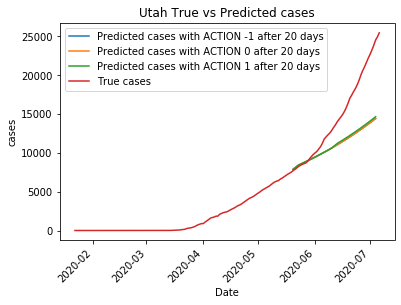

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


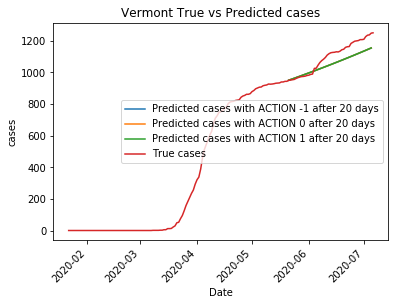

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


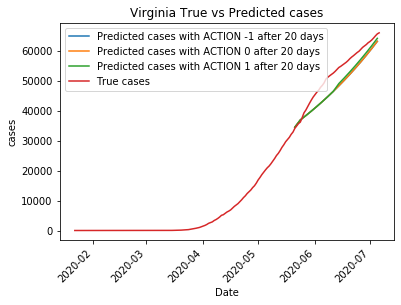

with action -1  STATE bef: 19.0  STATE aft: 19.0
with action 0  STATE bef: 19.0  STATE aft: 19.0
with action 1  STATE bef: 19.0  STATE aft: 19.0


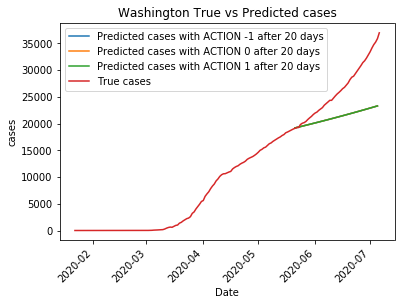

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


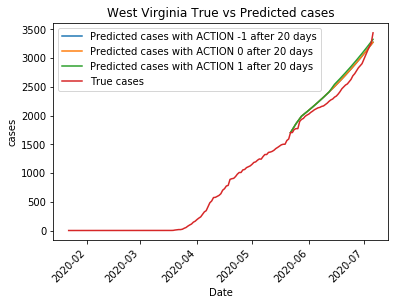

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


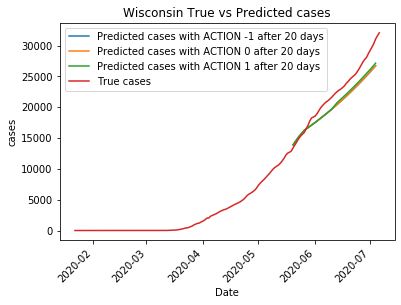

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


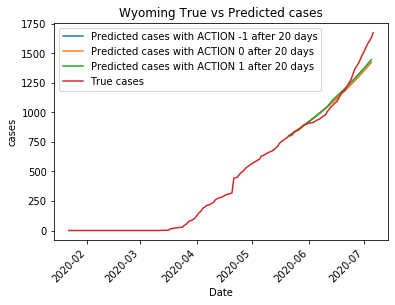

In [25]:
for region in m.df_trained.index:
    plot_pred_action(m, region, df, 45, 20, from_first=False)

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


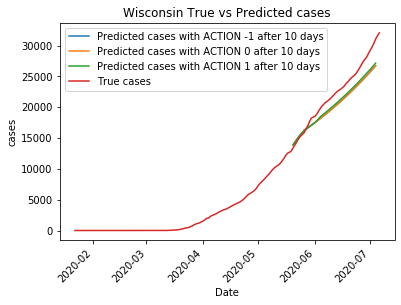

In [26]:
plot_pred_action(m, "Wisconsin", df, 45, 10, from_first=False)

with action -1  STATE bef: 12.0  STATE aft: 12.0
with action 0  STATE bef: 12.0  STATE aft: 12.0
with action 1  STATE bef: 12.0  STATE aft: 13.0


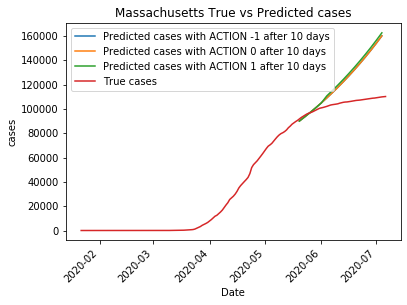

In [27]:
plot_pred_action(m, "Massachusetts", df, 45, 10, from_first=False)

## $\textbf{Counterfactual analysis}$

In [28]:
# Setting parameters
file = '05_27_states_combined_v2_w_trend.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file), parse_dates=["date"], index_col = 0)

In [34]:
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
feature_cols = ["mobility_score_trend", "cases_pct3", "cases_pct5"]  # action with no features
days_avg = m.days_avg

action_thresh = ([-250, 200], 1)
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples.tail()

ID       TIME  mobility_score_trend  cases_pct3  cases_pct5  \
1220  50 2020-05-10           2155.761905    0.038343    0.073080   
1221  50 2020-05-13           1298.714286    0.049283    0.074467   
1222  50 2020-05-16           1319.095238    0.074158    0.112677   
1223  50 2020-05-19           1213.290816    0.045564    0.095708   
1224  50 2020-05-22           1070.178571    0.034794    0.064987   

      mobility_score_trend-1  mobility_score_trend-2  cases_pct3-1  \
1220             3388.761905             4155.476190      0.055509   
1221             2155.761905             3388.761905      0.038343   
1222             1298.714286             2155.761905      0.049283   
1223             1319.095238             1298.714286      0.074158   
1224             1213.290816             1319.095238      0.045564   

      cases_pct3-2  cases_pct5-1  cases_pct5-2       r_t       r_t-1  \
1220      0.057658      0.097111      0.096307  1.038302  644.000000   
1221      0.055509      0.073080      0.097111  1.049352  668.666667   
1222      0.038343      0.074467      0.073080  1.074109  701.666667   
1223      0.049283      0.112677      0.074467  1.045555  753.666667   
1224      0.074158      0.095708      0.112677  1.019036  788.000000   

           r_t-2      RISK  mobility_score_trend_change ACTION    state  \
1220  610.333333  0.037587                  -766.714286     -1  Wyoming   
1221  644.000000  0.048173                 -1233.000000     -1  Wyoming   
1222  668.666667  0.071492                  -857.047619     -1  Wyoming   
1223  701.666667  0.044548                    20.380952      0  Wyoming   
1224  753.666667  0.018857                  -105.804422      0  Wyoming   

           cases  
1220  668.666667  
1221  701.666667  
1222  753.666667  
1223  788.000000  
1224  803.000000

2020-04-10 00:00:00 : Action 1
Transition not found: (16.0, 1)


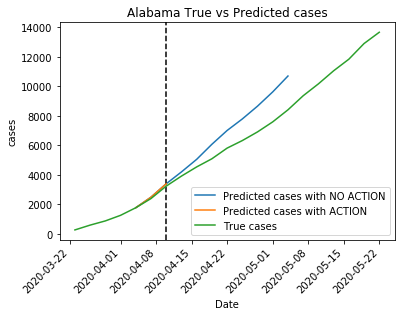

In [35]:
plot_pred_fact(m, "Alabama", df_samples, "20200404", n_days=30)

2020-04-04 00:00:00 : Action 1
with action 1  STATE bef: 1  STATE aft: 28.0
2020-04-16 00:00:00 : Action 1
with action 1  STATE bef: 45.0  STATE aft: 45.0
2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


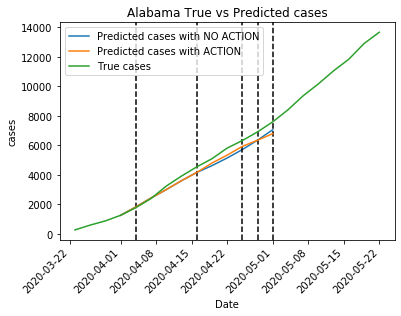

2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


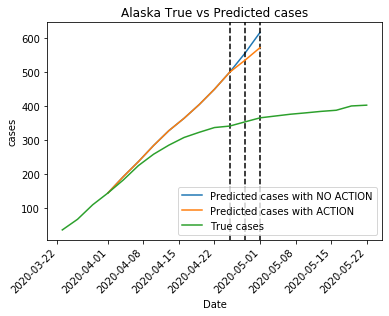

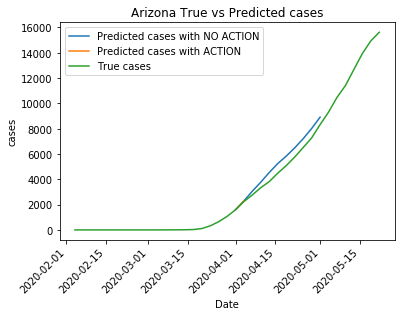

2020-04-04 00:00:00 : Action 1
Transition not found: (16, 1)


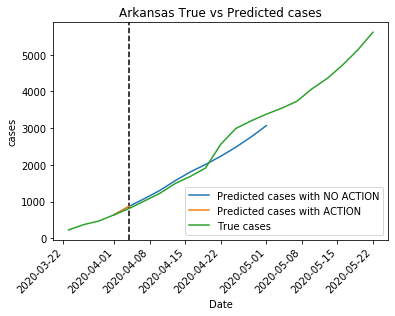

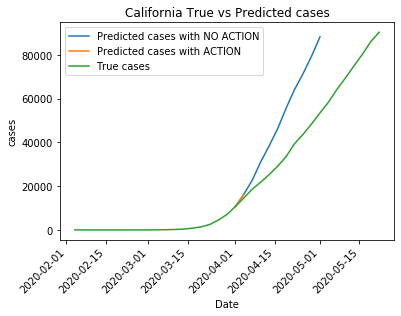

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-13 00:00:00 : Action -1
Transition not found: (37.0, -1)


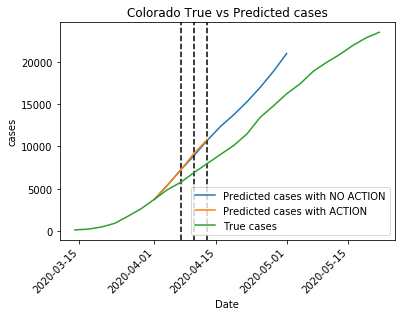

2020-04-19 00:00:00 : Action -1
Transition not found: (45.0, -1)


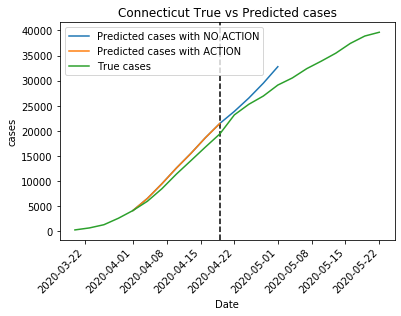

2020-04-19 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-22 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


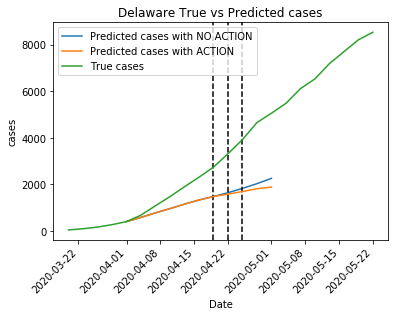

2020-04-22 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


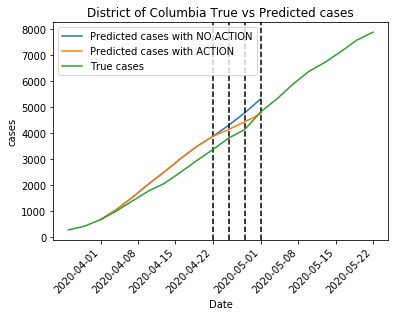

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 0  STATE aft: 1.0
2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 1.0  STATE aft: 24.0


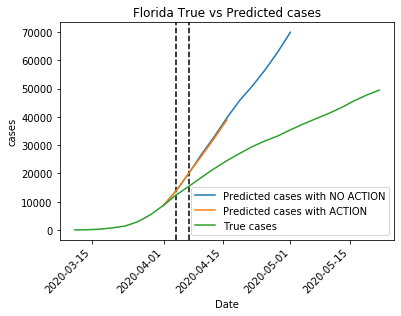

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 0.0  STATE aft: 1.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 1.0  STATE aft: 24.0
2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 24.0  STATE aft: 15.0


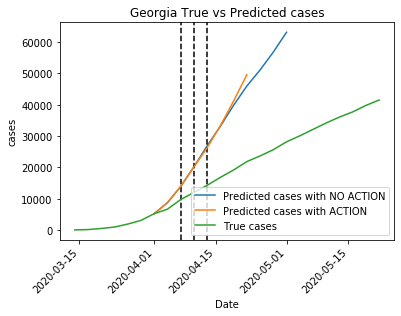

2020-04-13 00:00:00 : Action -1
Transition not found: (46.0, -1)


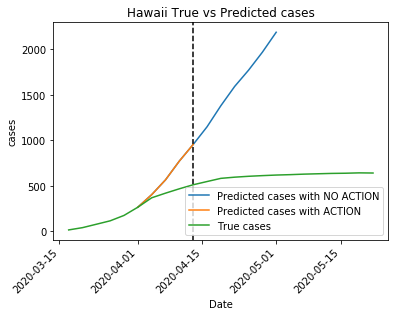

2020-04-04 00:00:00 : Action 1
Transition not found: (5, 1)


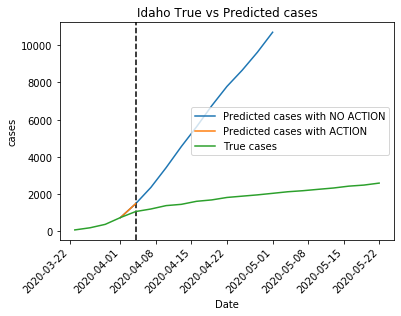

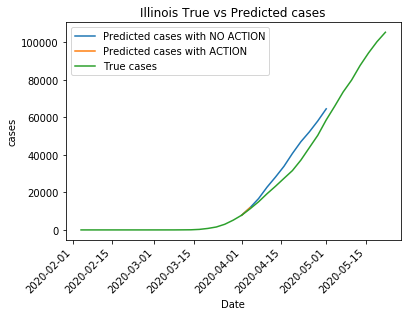

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-16 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-19 00:00:00 : Action -1
Transition not found: (37.0, -1)


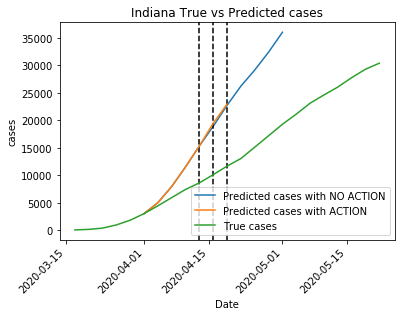

2020-04-19 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-22 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


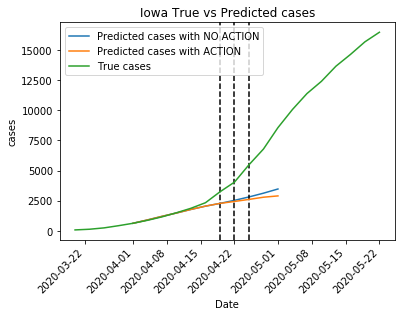

2020-04-13 00:00:00 : Action -1
Transition not found: (44.0, -1)


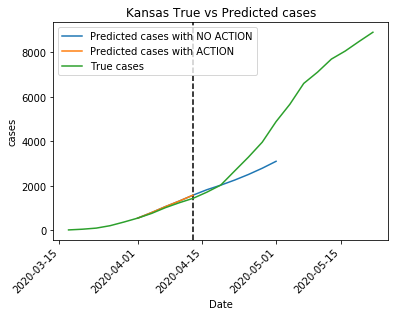

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 7.0  STATE aft: 45.0
2020-04-16 00:00:00 : Action -1
Transition not found: (45.0, -1)


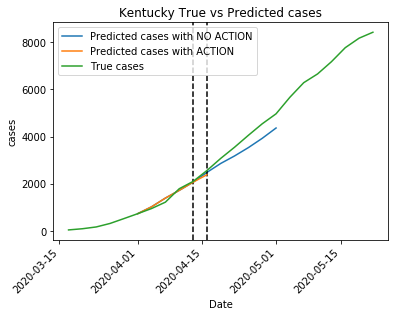

2020-04-19 00:00:00 : Action -1
Transition not found: (44.0, -1)


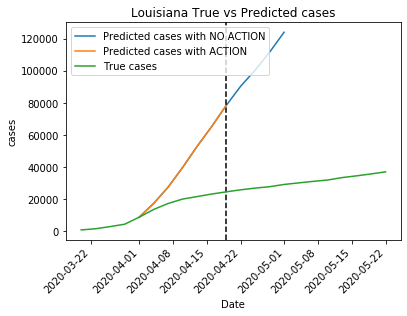

2020-04-04 00:00:00 : Action 1
with action 1  STATE bef: 28  STATE aft: 45.0
2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


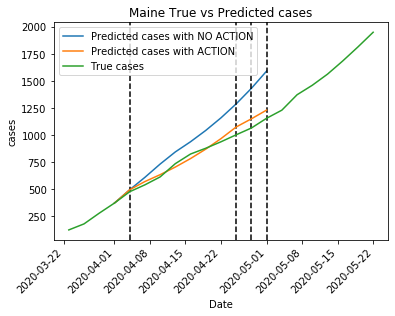

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-16 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-19 00:00:00 : Action -1
Transition not found: (37.0, -1)


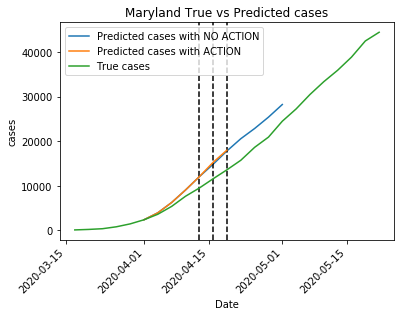

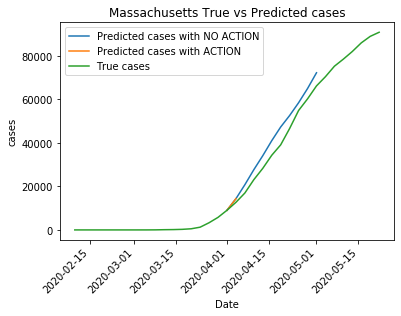

2020-04-19 00:00:00 : Action -1
Transition not found: (44.0, -1)


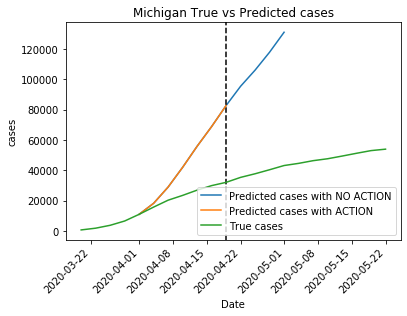

2020-04-13 00:00:00 : Action -1
Transition not found: (44.0, -1)


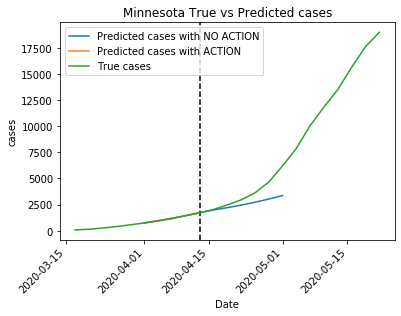

2020-04-04 00:00:00 : Action 1
with action 1  STATE bef: 26  STATE aft: 46.0
2020-04-10 00:00:00 : Action 1
with action 1  STATE bef: 7.0  STATE aft: 47.0
2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


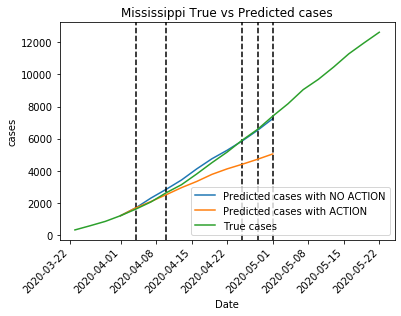

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 11.0  STATE aft: 35.0
2020-04-16 00:00:00 : Action -1
Transition not found: (35.0, -1)


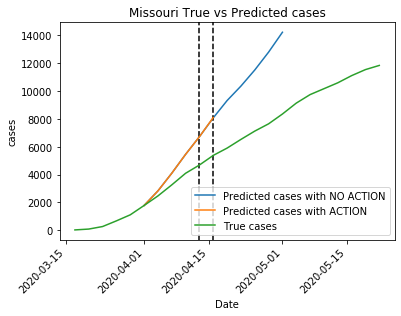

2020-04-04 00:00:00 : Action 1
with action 1  STATE bef: 28  STATE aft: 45.0
2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


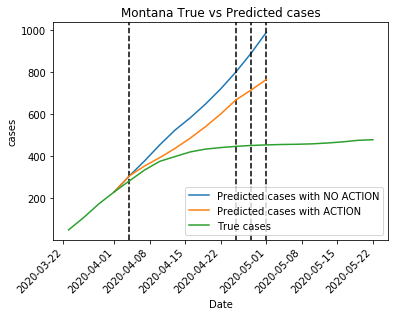

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-16 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-19 00:00:00 : Action -1
Transition not found: (37.0, -1)


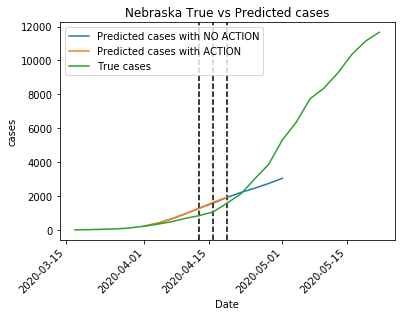

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 16.0  STATE aft: 15.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-13 00:00:00 : Action -1
Transition not found: (37.0, -1)


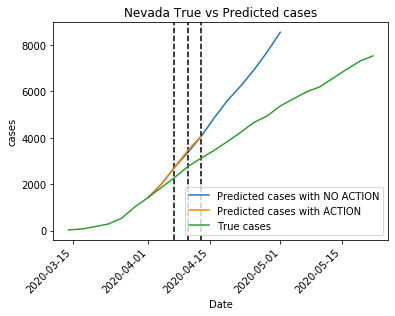

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 8  STATE aft: 1.0
2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 1.0  STATE aft: 24.0


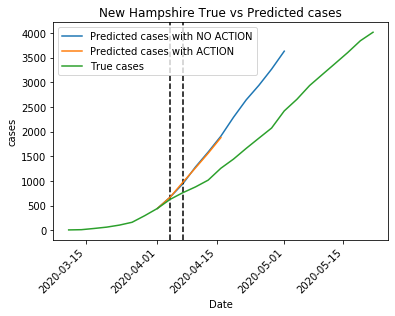

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 1.0  STATE aft: 24.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 24.0  STATE aft: 15.0
2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0


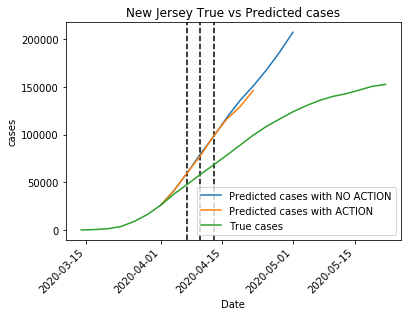

2020-04-19 00:00:00 : Action -1
Transition not found: (44.0, -1)


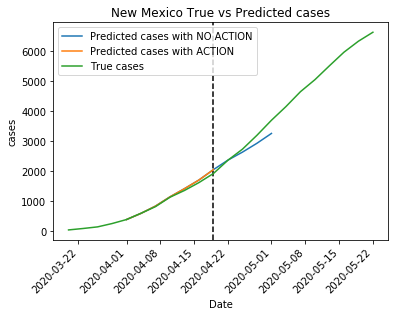

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 16  STATE aft: 15.0
2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0


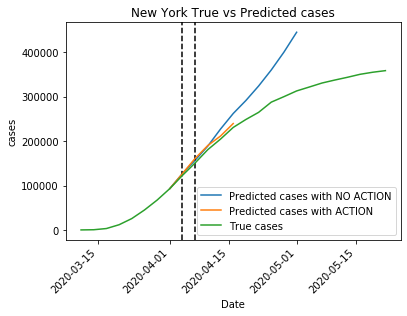

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-13 00:00:00 : Action -1
Transition not found: (37.0, -1)


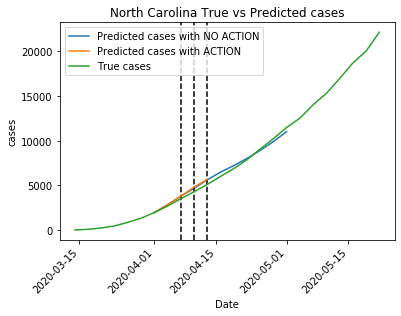

2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


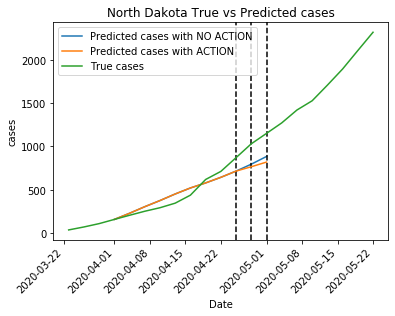

2020-04-19 00:00:00 : Action -1
Transition not found: (44.0, -1)


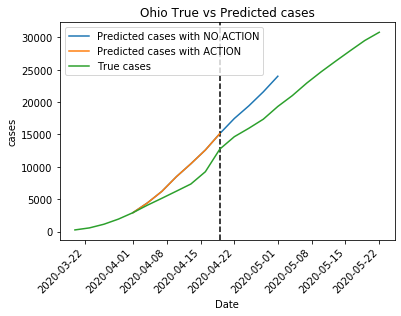

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-16 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-19 00:00:00 : Action -1
Transition not found: (37.0, -1)


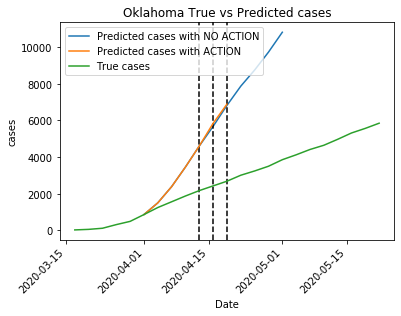

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 28  STATE aft: 15.0
2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0


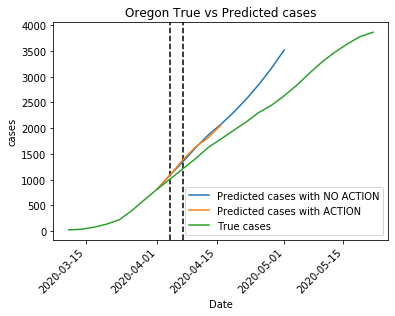

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-16 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-19 00:00:00 : Action -1
Transition not found: (37.0, -1)


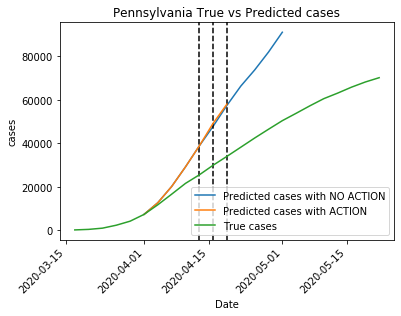

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 0  STATE aft: 1.0
2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 1.0  STATE aft: 24.0


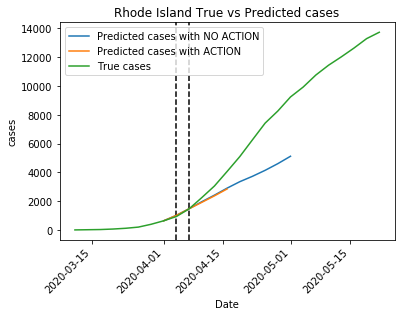

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-16 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-19 00:00:00 : Action -1
Transition not found: (37.0, -1)


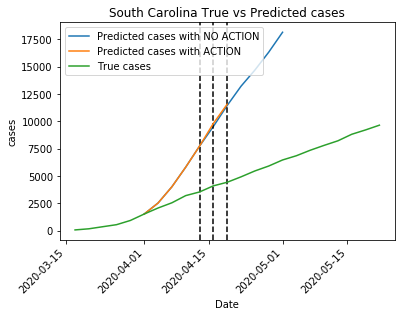

2020-04-19 00:00:00 : Action -1
Transition not found: (45.0, -1)


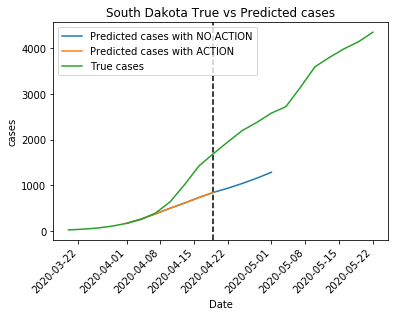

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 26.0  STATE aft: 24.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 24.0  STATE aft: 15.0
2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0


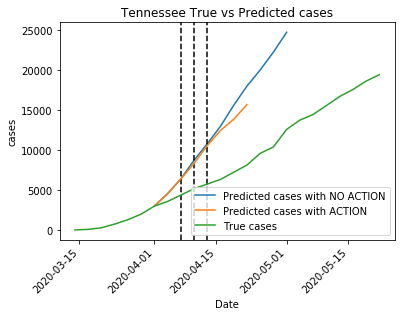

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 1.0  STATE aft: 24.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 24.0  STATE aft: 15.0
2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0


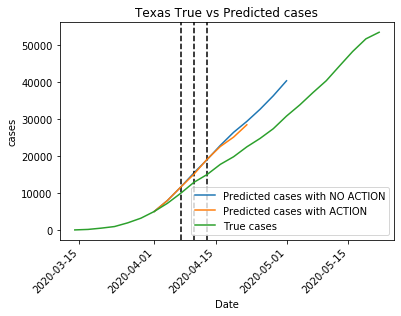

2020-04-13 00:00:00 : Action -1
Transition not found: (45.0, -1)


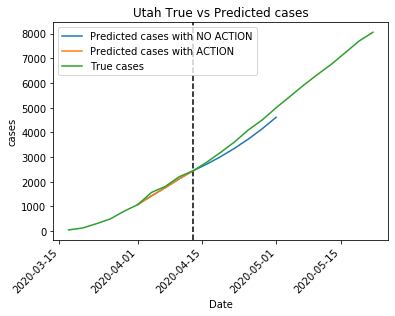

2020-04-13 00:00:00 : Action -1
Transition not found: (45.0, -1)


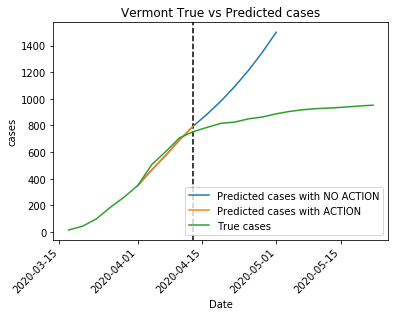

2020-04-13 00:00:00 : Action -1
with action -1  STATE bef: 28.0  STATE aft: 15.0
2020-04-16 00:00:00 : Action -1
with action -1  STATE bef: 15.0  STATE aft: 37.0
2020-04-19 00:00:00 : Action -1
Transition not found: (37.0, -1)


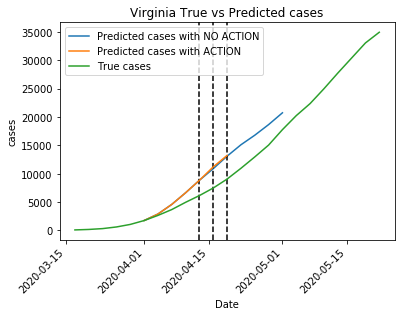

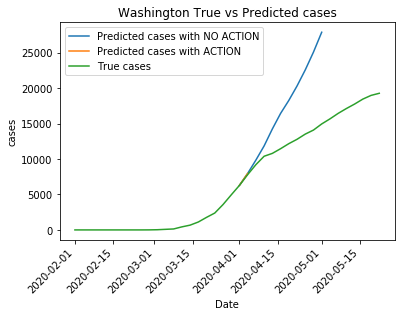

2020-04-13 00:00:00 : Action 1
Transition not found: (46.0, 1)


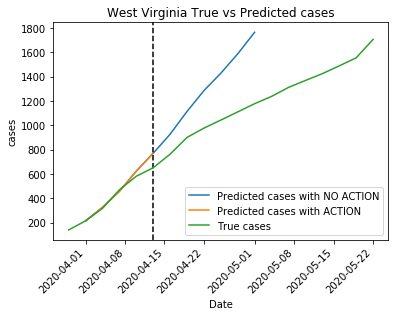

2020-04-19 00:00:00 : Action -1
Transition not found: (45.0, -1)


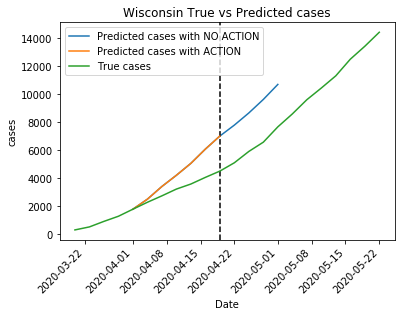

2020-04-25 00:00:00 : Action -1
with action -1  STATE bef: 22.0  STATE aft: 43.0
2020-04-28 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0
2020-05-01 00:00:00 : Action -1
with action -1  STATE bef: 43.0  STATE aft: 43.0


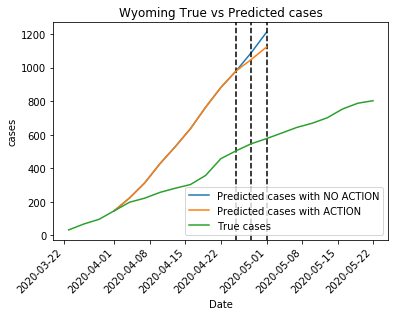

In [36]:
for region in m.df_trained.index:
    plot_pred_fact(m, region, df_samples, "20200401", n_days=30)

In [37]:
m.P_df

NEXT_CLUSTER
CLUSTER ACTION              
0       -1               1.0
         0               1.0
1       -1              24.0
         0              28.0
         1              28.0
...                      ...
45       1              45.0
46       0               7.0
47      -1              42.0
         0              14.0
         1              25.0

[100 rows x 1 columns]